In [13]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis #1

In [14]:
df = pd.read_csv("datasets/cleaned_dataset_filtered.csv")
df.head()

,influencer_name,Category,#Followers,#Posts,Likes,Comments,Total_Engagement,Engagement_Rate,Avg_Likes,Avg_Comments
0,makeupbynvs,beauty,1432.0,1,70.0,6.0,76.0,5.307263,70.0,6.0
1,jaquelinevandoski,beauty,137600.0,2,29031.0,142.0,29173.0,21.201308,14515.5,71.0
2,anisaartistry,beauty,64644.0,1,3125.0,33.0,3158.0,4.885217,3125.0,33.0
3,rubina_muartistry,beauty,496406.0,2,15346.0,152.0,15498.0,3.122041,7673.0,76.0
4,glaminfusion,beauty,4717.0,2,941.0,172.0,1113.0,23.595506,470.5,86.0


In [15]:
# Rename columns to easier names for modeling
df = df.rename(columns={
    "#Followers": "followers",
    "Engagement_Rate": "engagement_rate",
    "Category": "category"
})

# Convert to proper numeric types
df['followers'] = pd.to_numeric(df['followers'], errors='coerce')
df['engagement_rate'] = pd.to_numeric(df['engagement_rate'], errors='coerce')

# Convert category to string
df['category'] = df['category'].astype(str)

# Drop missing values
df = df.dropna(subset=['followers', 'engagement_rate', 'category'])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20648 entries, 0 to 20647
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   influencer_name   20648 non-null  object 
 1   category          20648 non-null  object 
 2   followers         20648 non-null  float64
 3   #Posts            20648 non-null  int64  
 4   Likes             20648 non-null  float64
 5   Comments          20648 non-null  float64
 6   Total_Engagement  20648 non-null  float64
 7   engagement_rate   20648 non-null  float64
 8   Avg_Likes         20648 non-null  float64
 9   Avg_Comments      20648 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 1.6+ MB


In [16]:
df['log_followers'] = np.log10(df['followers'])
df

,influencer_name,category,followers,#Posts,Likes,Comments,Total_Engagement,engagement_rate,Avg_Likes,Avg_Comments,log_followers
0,makeupbynvs,beauty,1432.0,1,70.0,6.0,76.0,5.307263,70.0,6.0,3.155943
1,jaquelinevandoski,beauty,137600.0,2,29031.0,142.0,29173.0,21.201308,14515.5,71.0,5.138618
2,anisaartistry,beauty,64644.0,1,3125.0,33.0,3158.0,4.885217,3125.0,33.0,4.810528
3,rubina_muartistry,beauty,496406.0,2,15346.0,152.0,15498.0,3.122041,7673.0,76.0,5.695837
4,glaminfusion,beauty,4717.0,2,941.0,172.0,1113.0,23.595506,470.5,86.0,3.673666
...,...,...,...,...,...,...,...,...,...,...,...
20643,alliesevdalis,other,28861.0,2,1435.0,34.0,1469.0,5.089914,717.5,17.0,4.460311
20644,callmekimhq,other,2461.0,2,146.0,5.0,151.0,6.135717,73.0,2.5,3.391112
20645,smallstepsaregiantleaps,other,9202.0,1,280.0,2.0,282.0,3.064551,280.0,2.0,3.963882
20646,alingzhang,other,4597.0,1,139.0,1.0,140.0,3.045464,139.0,1.0,3.662475


In [17]:
df.groupby('category')[['followers', 'engagement_rate']].agg(['mean', 'median', 'std'])


followers                        engagement_rate            \
                   mean   median           std            mean    median   
category                                                                   
beauty    136361.253918  21000.0  6.069772e+05        7.863346  4.885217   
family    118652.779299  11896.0  5.822665e+05        9.330107  5.923154   
fashion   189256.202838  25152.5  1.398061e+06        8.801604  5.699963   
fitness   173591.203785  29852.0  7.597589e+05        6.725009  4.638071   
food       40244.801237  13198.0  1.216309e+05        7.121026  4.472327   
interior   58073.077922  20436.0  1.483681e+05        6.269305  4.064016   
other     211240.196122  11309.0  1.945876e+06        6.573540  3.829233   
pet        76430.923077  21548.5  2.968730e+05        8.306374  5.637016   
travel     58995.063252  14587.0  2.448719e+05        9.567545  6.420765   

                     
                std  
category             
beauty     9.651835  
family    20.140309  
fashion   10.442973  
fitness    7.053396  
food      11.857105  
interior   7.557277  
other      9.695673  
pet        8.984351  
travel    11.272611

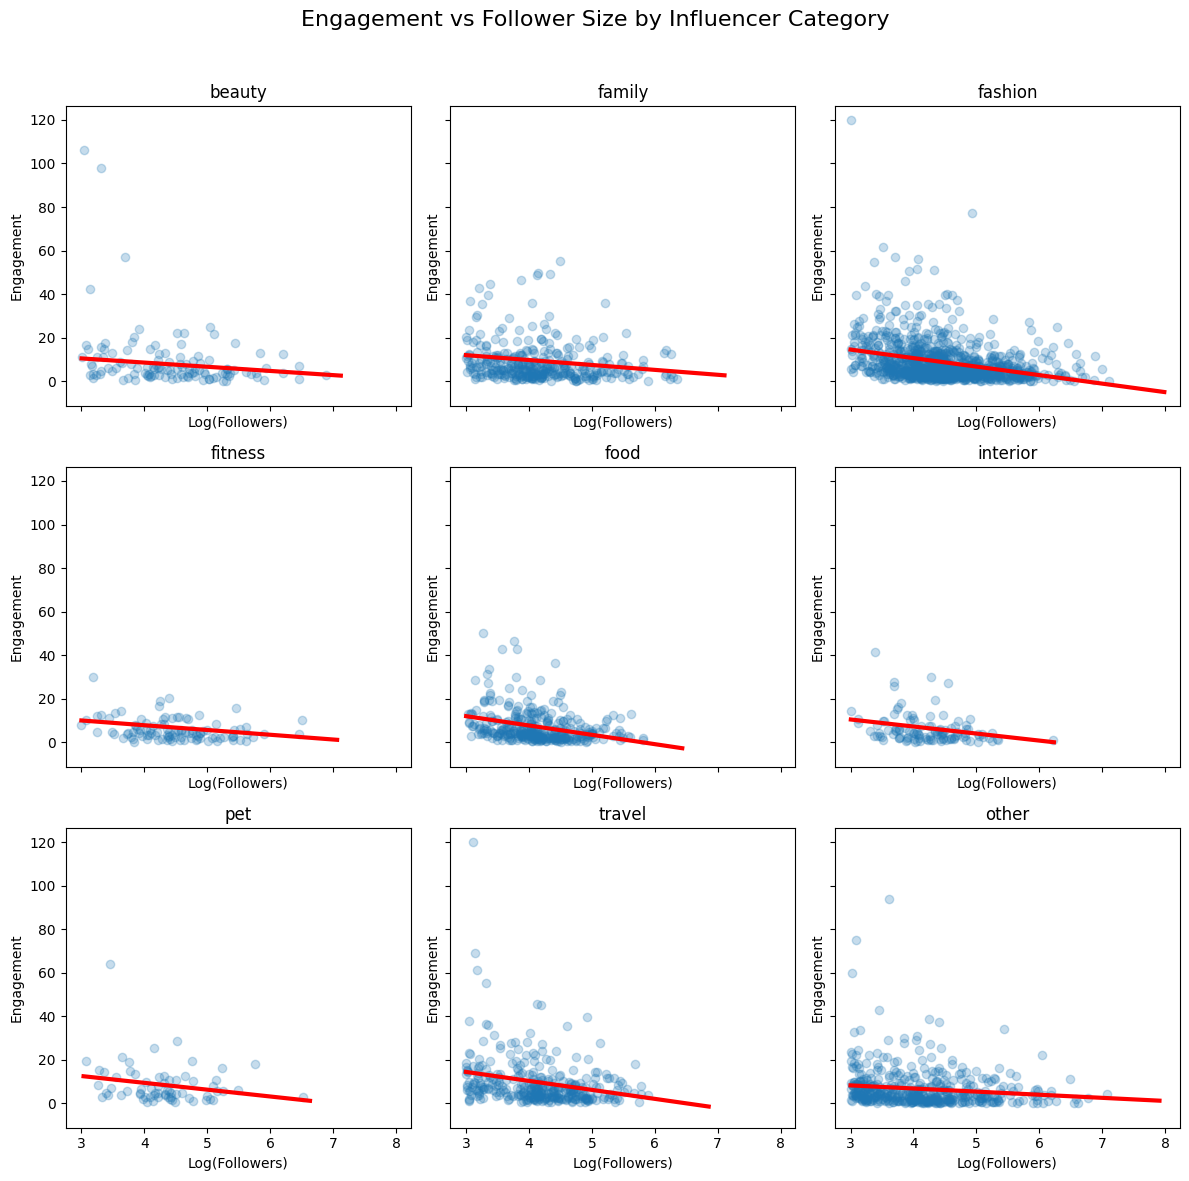

In [18]:
df_viz = df.sample(n=3000, random_state=42)

categories = df['category'].unique()
n = len(categories)

cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, cat in enumerate(categories):
    # Use SAMPLED data for scatter
    subset_viz = df_viz[df_viz['category'] == cat]

    x_viz = subset_viz['log_followers']
    y_viz = subset_viz['engagement_rate']

    # Clip outliers for visibility
    y_clip = np.clip(y_viz, 0, 120)

    # Scatter (light + transparent)
    axes[i].scatter(x_viz, y_clip, alpha=0.25)

    # ---- REGRESSION LINE (FULL DATA) ----
    full_subset = df[df['category'] == cat]

    x_full = full_subset['log_followers']
    y_full = full_subset['engagement_rate']

    m, b = np.polyfit(x_full, y_full, 1)
    x_vals = np.linspace(x_full.min(), x_full.max(), 100)
    y_vals = m * x_vals + b

    axes[i].plot(x_vals, y_vals, linewidth=3, color='red')

    axes[i].set_title(cat)
    axes[i].set_xlabel("Log(Followers)")
    axes[i].set_ylabel("Engagement")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Engagement vs Follower Size by Influencer Category", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Our visualization shows that engagement rate consistently decreases as follower size increases across all influencer categories. However, the steepness of this decline differs by category, indicating that follower size predicts engagement differently depending on the category. This directly answers our research question by confirming a category-specific relationship between audience size and engagement. From a business analytics perspective, this means that the effectiveness of large versus small influencers is highly dependent on industry. As a result, companies should tailor their influencer marketing strategies by category rather than relying on follower count alone to maximize return on investment.

# EDA

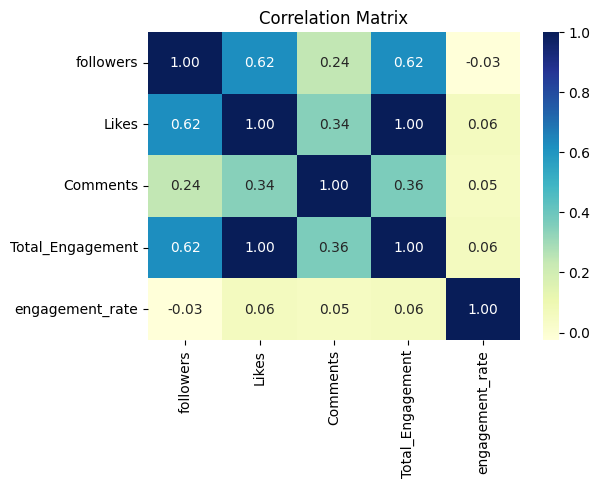

In [19]:
cols = ['followers', 'Likes', 'Comments', 'Total_Engagement', 'engagement_rate']
correlations = df[cols].corr()['engagement_rate'].sort_values(ascending=False)

corr_matrix = df[cols].corr()
corr_matrix

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Correlation Matrix')
plt.show()

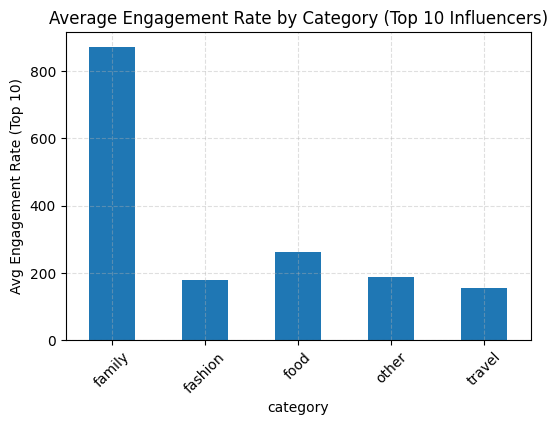

In [23]:
top10 = df.sort_values(by='engagement_rate', ascending=False).head(10)
top10[['influencer_name', 'category','followers', 'engagement_rate']]

cat_avg_top10 = top10.groupby('category')['engagement_rate'].mean()

plt.figure(figsize=(6,4))
cat_avg_top10.plot(kind='bar')
plt.ylabel('Avg Engagement Rate (Top 10)')
plt.title('Average Engagement Rate by Category (Top 10 Influencers)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

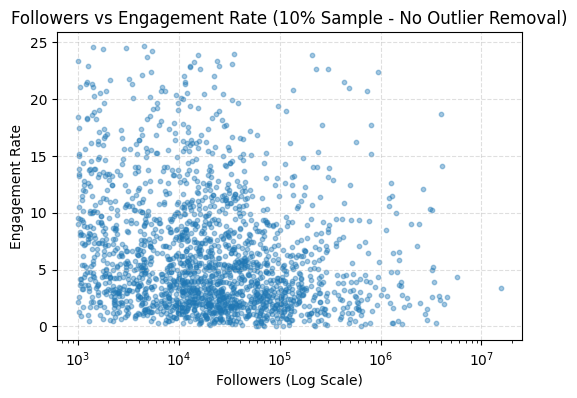

In [25]:
filtered_df = df[df['engagement_rate'] < df['engagement_rate'].quantile(0.95)]

sample_df = filtered_df.sample(frac=0.10, random_state=42)
plt.figure(figsize=(6,4))
plt.scatter(sample_df['followers'], sample_df['engagement_rate'], alpha=0.4, s=10)
plt.xscale('log')
plt.xlabel('Followers (Log Scale)')
plt.ylabel('Engagement Rate')
plt.title('Followers vs Engagement Rate (10% Sample - No Outlier Removal)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()